# Libraries
Load the necessary libraries.

In [13]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , Conv2DTranspose, Input , UpSampling2D , Concatenate , ReLU 
from tensorflow.keras.models import Model
from tensorflow import io
from tensorflow import image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split , KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.image_utils import array_to_img, img_to_array, load_img
from tensorflow.keras.losses import Loss
from tensorflow.keras.metrics import MeanIoU , AUC , IoU , Precision , Recall
from tensorflow.nn import sparse_softmax_cross_entropy_with_logits
import keras.backend as K
from focal_loss import sparse_categorical_focal_loss

import matplotlib.pyplot as plt
import numpy as np
import os
import time
import pandas as pd
import imageio
import PIL
import IPython
import cv2
import random

%matplotlib inline 

Checking whether the GPU is being used to train the model.

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Preprocessing
Preprocessing the image data, this includes resize all the image into 128x128. Making all the image to be same size is required for training an image processing model. Smaller size images also take less memory space and time to train.

Not only that, normalization is done to convert all the pixels into a same range, that is from 0 to 1. The small pixel values after normalization allow the model to be trained and reach the minimum error faster.

In [3]:
def resize_images(img):
    img = tf.image.resize(img, (128, 128) , method = "nearest")
    return img.numpy()

def normalize_img(img): 
    img = resize_images(img)
    img = tf.cast(img, tf.float32) / 255.0   
    return img.numpy()

# Data preparation
Now, load the images data. Since the images are retrieved from video footage during different timing, I have split the training and testing data with the proportion of 7:3 in every video file. This is to ensure that road scene from different weather or road condition is being trained, thus, less bias to the dataset.

In [4]:
def load_images(train_size = 0.7 , test_size = 0.3 ):
    videos = sorted(os.listdir("dataset/images"))
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    for video in videos:
        imgs = os.listdir("dataset/images/" + video)
        lbls = os.listdir("dataset/labels/" + video)
        for img in imgs[ : int(len(imgs)*train_size)]:
            img_load = normalize_img(imageio.imread(os.path.join("dataset/images/" + video, img)))
            lbl_load = resize_images(imageio.imread(os.path.join("dataset/labels/" + video, img)))
#             img_load = imageio.imread(os.path.join("dataset/images/" + video, img))
            x_train.append(img_load)
            y_train.append(lbl_load)
        
        for img2 in imgs[ int(len(imgs)*train_size) : ]:
            img_load = normalize_img(imageio.imread(os.path.join("dataset/images/" + video, img)))
            lbl_load = resize_images(imageio.imread(os.path.join("dataset/labels/" + video, img)))
#             img_load = imageio.imread(os.path.join("dataset/images/" + video, img))
            x_test.append(img_load)
            y_test.append(lbl_load) 
    
    return np.array(x_train,dtype=float),np.array(x_test,dtype=float),np.array(y_train,dtype=int),np.array(y_test,dtype=int)

## Splitting the dataset
Split the dataset into training, validation and testing set. This is to ensure the model has enough data to test and validate the performance. Thus, it would be less over-fitting.

In [5]:
X_train , X_val , y_train , y_val = load_images(train_size = 0.7)
X_train , X_test , y_train , y_test = train_test_split(X_train , y_train , test_size = 0.33 , random_state=40)

C:\Users\RYUGAAX\AppData\Local\Temp\ipykernel_14096\1530484870.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_load = normalize_img(imageio.imread(os.path.join("dataset/images/" + video, img)))
C:\Users\RYUGAAX\AppData\Local\Temp\ipykernel_14096\1530484870.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  lbl_load = resize_images(imageio.imread(os.path.join("dataset/labels/" + video, img)))
C:\Users\RYUGAAX\AppData\Local\Temp\ipykernel_14096\1530484870.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. T

Show the images for example.

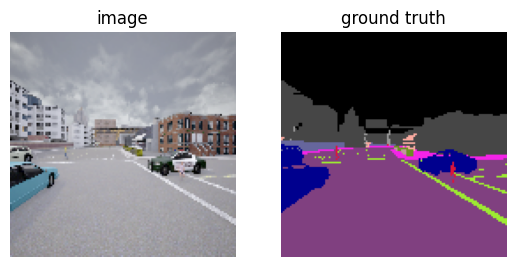

In [6]:
plt.subplot(1,2,1)
plt.imshow(array_to_img(X_train[0]))
plt.title('image')
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(y_train[0])
plt.title('ground truth')
plt.axis("off")

plt.show()

## Labelling pixels
Label each pixel with a class according to the pixel colour. The author of the dataset has given a CSV file recording the semantic class and its colour value in the laballed image.

Following is the table regarding the semantic classes details.

In [7]:
classes_rgb = pd.read_csv("dataset/classes_rgb_values.csv")
classes_rgb["class_weight"] = 1/classes_rgb["relative_percentile_frequency"]
classes_rgb

,index,semantic_class,rgb_values,relative_percentile_frequency,class_weight
0,0,Traffic Sign,"[220,220,0]",0.05,20.000000
1,1,Building,"[70,70,70]",14.08,0.071023
2,2,Fence,"[190,153,153]",0.28,3.571429
3,3,Other,"[250,170,160]",0.29,3.448276
4,4,Pedestrian,"[220,20,60]",1.02,0.980392
5,5,Pole,"[153,153,153]",0.74,1.351351
6,6,Road Line,"[157,234,50]",1.86,0.537634
7,7,Road,"[128,64,128]",33.80,0.029586
8,8,Sidewalk,"[244,35,232]",5.85,0.170940
9,9,Vegetation,"[107,142,35]",4.78,0.209205


In [8]:
class_weight = dict(enumerate(classes_rgb["class_weight"].values))
class_weight

{0: 20.0,
 1: 0.07102272727272728,
 2: 3.571428571428571,
 3: 3.4482758620689657,
 4: 0.9803921568627451,
 5: 1.3513513513513513,
 6: 0.5376344086021505,
 7: 0.02958579881656805,
 8: 0.17094017094017094,
 9: 0.20920502092050208,
 10: 0.27548209366391185,
 11: 1.2195121951219512,
 12: 0.030478512648582746}

Now, make a function that can label the pixels of the labelled images with an integer class.

In [9]:
# follow the sequence of the table above
label_list = [[220,220,0], [70,70,70], [190,153,153], [250,170,160], [220,20,60], [153,153,153], [157,234,50],
             [128,64,128], [244,35,232], [107,142,35], [0,0,142], [102,102,156], [0,0,0]]

def pixels2labels(image, label_list):
    label = np.zeros((128,128), dtype = np.int32)
    for i in range(len(image)):
        for j in range(len(image[i])):
             label[i][j] = label_list.index(list(image[i][j]))
    return label

In [10]:
y_train[0]

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[128,  64, 128],
        [128,  64, 128],
        [128,  64, 128],
        ...,
        [128,  64, 128],
        [128,  64, 128],
        [128,  64, 128]],

       [[128,  64, 128],
        [128,  64, 128],
        [128,  64, 128],
        ...,
        [128,  64, 128],
        [128,  64, 128],
        [128,  64, 128]],

       [[128,  64, 128],
        [128,  64, 128],
        [128,  64, 128],
        ...,
        [128,  64, 128],
        [128,  64, 128],
        [128,  64, 128]]

In [11]:
y_train_label = np.array([pixels2labels(i , label_list) for i in y_train])
y_val_label = np.array([pixels2labels(i , label_list) for i in y_val])
y_test_label = np.array([pixels2labels(i , label_list) for i in y_test])

In [12]:
print( np.shape(y_train_label) , '\n' , y_train_label[0])

(5039, 128, 128) 
 [[12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 ...
 [ 7  7  7 ...  7  7  7]
 [ 7  7  7 ...  7  7  7]
 [ 7  7  7 ...  7  7  7]]


# Convolutional Neural Network model
Following is the CNN model used to train with the dataset.

Firstly, I have defined the classes of different modules in the network. Each module means the stage that the images will go through in training and predicting.

In [27]:
# convolute the image
class convolution_module(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, padding="valid"):
        super().__init__()
        self.conv = Conv2D(filters, kernel_size, padding=padding)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = ReLU()
        
    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.relu(x)
        return x

# downsample would convolute the image twice and do max-pooling
class downsample_module(tf.keras.layers.Layer):
    
    def __init__(self, filters, kernel_size, pool_size, padding="valid"):
        super().__init__()
        self.conv_module1 = convolution_module(filters, kernel_size, padding)
        self.conv_module2 = convolution_module(filters, kernel_size, padding)
        self.maxpool = MaxPooling2D(pool_size)
        
    def call(self, inputs):
        x = self.conv_module1(inputs)
        x = self.conv_module2(x)
        x = self.maxpool(x)
        return x
    
# deconvolute the image
class deconvolution_module(tf.keras.layers.Layer):  
    def __init__(self, filters, kernel_size):
        super().__init__()
        self.deconv = Conv2DTranspose(filters, kernel_size, strides=kernel_size, padding="same")
        self.bn = tf.keras.layers.BatchNormalization()
        
        self.relu = ReLU()
        
    def call(self, inputs):
        x = self.deconv(inputs)
        x = self.bn(x)
        x = self.relu(x) 
        return x
    
# upsample would deconvolute the image once and comvolute twice
class upsample_module(tf.keras.layers.Layer):
    
    def __init__(self, filters, kernel_size, deconv_kernel, padding="valid"):
        super().__init__()
        self.deconv_module = deconvolution_module(filters, deconv_kernel)
        self.conv_module1 = convolution_module(filters, kernel_size, padding)
        self.conv_module2 = convolution_module(filters, kernel_size, padding)
        
    def call(self, inputs):
        x = self.deconv_module(inputs)
        x = self.conv_module1(x)
        x = self.conv_module2(x)
        return x

## Baseline model
I would use a fully convolutional network as my baseline model. The architecture of this model is purely downsampling and upsampling the image only.

In [28]:
class fully_convolutional_network(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        self.downsample1 = downsample_module(64, (3, 3), (2, 2), "same") #64x64
        self.downsample2 = downsample_module(64, (3, 3), (2, 2), "same") #32x32
        self.downsample3 = downsample_module(128, (3, 3), (2, 2), "same") #16x16
        self.downsample4 = downsample_module(128, (3, 3), (2, 2), "same") #8x8
        self.conv_module = convolution_module(256, T (3, 3), "same")
        
        self.deconv_module1 = deconvolution_module(64, (2, 2)) #16x16
        self.deconv_module2 = deconvolution_module(32, (8, 8)) #128x128
        
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.dense = tf.keras.layers.Dense(16, activation="elu")
        self.softmax = tf.keras.layers.Dense(13, activation="softmax") #probability distribution of each 13 classes
    
    def call(self, inputs):
        
        x = self.downsample1(inputs)
        x = self.downsample2(x)
        x = self.downsample3(x)
        x = self.downsample4(x)
        x = self.conv_module(x)
        
        x = self.deconv_module1(x)        
        x = self.deconv_module2(x)
        
        x = self.dropout(x)
        x = self.dense(x)
        x = self.softmax(x)

        return x

### Initiate the baseline model
initiate the baseline model with the architecture above and compile it with MeanIoU as the metrics and SparseCategoricalCrossentropy as the loss function.

In [14]:
class self_iou(MeanIoU):
    def __init__(self, num_classes, name='iou', dtype=None):
        super().__init__(num_classes=num_classes, name=name, dtype=dtype)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Calculate the IoU for each class
        y_flat = y_true
        pred = tf.math.argmax(y_pred , axis =3)
        if y_true.shape.ndims == y_pred.shape.ndims:
            y_flat = tf.squeeze(y_flat, axis=[-1])
        y_true_int = tf.cast(y_flat, tf.int32)
        class_counts = tf.math.bincount(y_true_int)
        class_counts = tf.math.reciprocal_no_nan(tf.cast(class_counts, self.dtype))
        weight = tf.gather(class_counts, y_true_int)
        super().update_state(y_true, pred, sample_weight=weight)
        
class self_precision(Precision):
    def __init__(self, name='precision', dtype=None):
        super().__init__(name=name, dtype=dtype)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_flat = y_true
        pred = tf.math.argmax(y_pred , axis =3)
        if y_true.shape.ndims == y_pred.shape.ndims:
            y_flat = tf.squeeze(y_flat, axis=[-1])
        y_true_int = tf.cast(y_flat, tf.int32)

        class_counts = tf.math.bincount(y_true_int)
        class_counts = tf.math.reciprocal_no_nan(tf.cast(class_counts, self.dtype))
        weight = tf.gather(class_counts, y_true_int)
        super().update_state(y_true, pred, sample_weight=weight)

class self_recall(Recall):
    def __init__(self, name='recall', dtype=None):
        super().__init__(name=name, dtype=dtype)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_flat = y_true
        pred = tf.math.argmax(y_pred , axis =3)
        if y_true.shape.ndims == y_pred.shape.ndims:
            y_flat = tf.squeeze(y_flat, axis=[-1])
        y_true_int = tf.cast(y_flat, tf.int32)

        class_counts = tf.math.bincount(y_true_int)
        class_counts = tf.math.reciprocal_no_nan(tf.cast(class_counts, self.dtype))
        weight = tf.gather(class_counts, y_true_int)
        super().update_state(y_true, pred, sample_weight=weight)
        
def self_loss(y_true, y_pred):
    weights = tf.constant(list(class_weight.values()))
    weights = tf.gather(weights, y_true)
    loss = tf.compat.v1.losses.sparse_softmax_cross_entropy(y_true, y_pred, weights)
    return loss * weights

In [90]:
fcn = fully_convolutional_network()
metrics = [self_iou(num_classes=13) , self_precision() , self_recall()]
fcn.compile(loss= self_loss , metrics=metrics)

### Train the baseline model
Train the baseline model with the training, validation dataset and set the epochs to be 10 and batch size of 20.

In [91]:
baseline_history = fcn.fit( X_train , y_train_label , batch_size = 32, epochs= 200 , validation_data = (X_val , y_val_label))

Epoch 1/200
158/158 [==============================] - 27s 146ms/step - loss: 0.0623 - iou: 0.1734 - precision: 0.9592 - recall: 0.9685 - val_loss: 0.0945 - val_iou: 0.0599 - val_precision: 0.9291 - val_recall: 1.0000
Epoch 2/200
158/158 [==============================] - 22s 137ms/step - loss: 0.0551 - iou: 0.3449 - precision: 0.9925 - recall: 0.9677 - val_loss: 0.0923 - val_iou: 0.0725 - val_precision: 0.9316 - val_recall: 0.9955
Epoch 3/200
158/158 [==============================] - 22s 137ms/step - loss: 0.0531 - iou: 0.4705 - precision: 0.9948 - recall: 0.9823 - val_loss: 0.0816 - val_iou: 0.2091 - val_precision: 0.9448 - val_recall: 0.9908
Epoch 4/200
158/158 [==============================] - 22s 136ms/step - loss: 0.0514 - iou: 0.6079 - precision: 0.9951 - recall: 0.9896 - val_loss: 0.0748 - val_iou: 0.3490 - val_precision: 0.9545 - val_recall: 0.9952
Epoch 5/200
158/158 [==============================] - 22s 136ms/step - loss: 0.0509 - iou: 0.6431 - precision: 0.9961 - recall:

158/158 [==============================] - 21s 136ms/step - loss: 0.0493 - iou: 0.7345 - precision: 0.9984 - recall: 0.9955 - val_loss: 0.0658 - val_iou: 0.6056 - val_precision: 0.9910 - val_recall: 0.9917
Epoch 76/200
158/158 [==============================] - 22s 136ms/step - loss: 0.0493 - iou: 0.7351 - precision: 0.9984 - recall: 0.9957 - val_loss: 0.0660 - val_iou: 0.5922 - val_precision: 0.9924 - val_recall: 0.9848
Epoch 77/200
158/158 [==============================] - 22s 136ms/step - loss: 0.0492 - iou: 0.7395 - precision: 0.9985 - recall: 0.9956 - val_loss: 0.0659 - val_iou: 0.5880 - val_precision: 0.9934 - val_recall: 0.9859
Epoch 78/200
158/158 [==============================] - 22s 136ms/step - loss: 0.0492 - iou: 0.7352 - precision: 0.9983 - recall: 0.9958 - val_loss: 0.0659 - val_iou: 0.6011 - val_precision: 0.9879 - val_recall: 0.9939
Epoch 79/200
158/158 [==============================] - 22s 136ms/step - loss: 0.0492 - iou: 0.7346 - precision: 0.9984 - recall: 0.9957 

158/158 [==============================] - 21s 136ms/step - loss: 0.0490 - iou: 0.8030 - precision: 0.9985 - recall: 0.9960 - val_loss: 0.0657 - val_iou: 0.6250 - val_precision: 0.9902 - val_recall: 0.9912
Epoch 150/200
158/158 [==============================] - 22s 136ms/step - loss: 0.0490 - iou: 0.8031 - precision: 0.9986 - recall: 0.9960 - val_loss: 0.0659 - val_iou: 0.6201 - val_precision: 0.9942 - val_recall: 0.9813
Epoch 151/200
158/158 [==============================] - 22s 136ms/step - loss: 0.0491 - iou: 0.8054 - precision: 0.9986 - recall: 0.9960 - val_loss: 0.0656 - val_iou: 0.6363 - val_precision: 0.9932 - val_recall: 0.9884
Epoch 152/200
158/158 [==============================] - 22s 136ms/step - loss: 0.0490 - iou: 0.8001 - precision: 0.9987 - recall: 0.9961 - val_loss: 0.0655 - val_iou: 0.6347 - val_precision: 0.9937 - val_recall: 0.9897
Epoch 153/200
158/158 [==============================] - 21s 136ms/step - loss: 0.0489 - iou: 0.8064 - precision: 0.9986 - recall: 0.9

### Prediction of the baseline model
Use the baseline model to predict the image segmentation outcome.

In [41]:
# function that turns the integer labelled image into rgb value
def labels2pixels(image, label_list):
    indices1D = image.ravel()
    pixels1D = np.array(label_list, dtype=float)[indices1D]
    return pixels1D.reshape((image.shape[0], image.shape[1], 3)) / 255

In [92]:
predictions = fcn.predict(X_val)

102/102 [==============================] - 4s 34ms/step


Now, get the class that has the highest probability.

In [93]:
prediction_classes = np.argmax(predictions , axis = 3)

Show the outcome of the prediction.

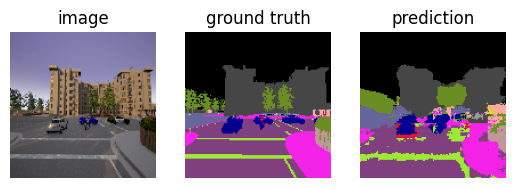

In [94]:
plt.subplot(1,3,1)
plt.imshow(array_to_img(X_val[1]))
plt.title('image')
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(y_val[0])
plt.title('ground truth')
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(labels2pixels(prediction_classes[0],label_list))
plt.title('prediction')
plt.axis("off")

plt.show()

### Evaluation of the baseline model
This part is showing the training history and the score of the baseline model.

In [45]:
# function to plot the training history as graph
def plot_training_history(history , monitors=['loss' , 'iou' , 'precision' , 'recall']):
    fig,axs = plt.subplots(2,2,sharex='all',figsize=(20,8))
    
    for ax,monitor in zip(axs.flat,monitors):
        loss , val_loss = history.history[monitor] , history.history['val_' + monitor]
        
        epochs = range(1,len(loss)+1)
        
        ax.plot(epochs , loss , 'g.' , label = monitor)
        ax.plot(epochs , val_loss , 'r.' , label='validation ' + monitor)
        ax.set_xlim([0,len(loss)])
        ax.title.set_text('training and validation '+monitor)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(monitor)
        ax.legend()
        
    plt.show()

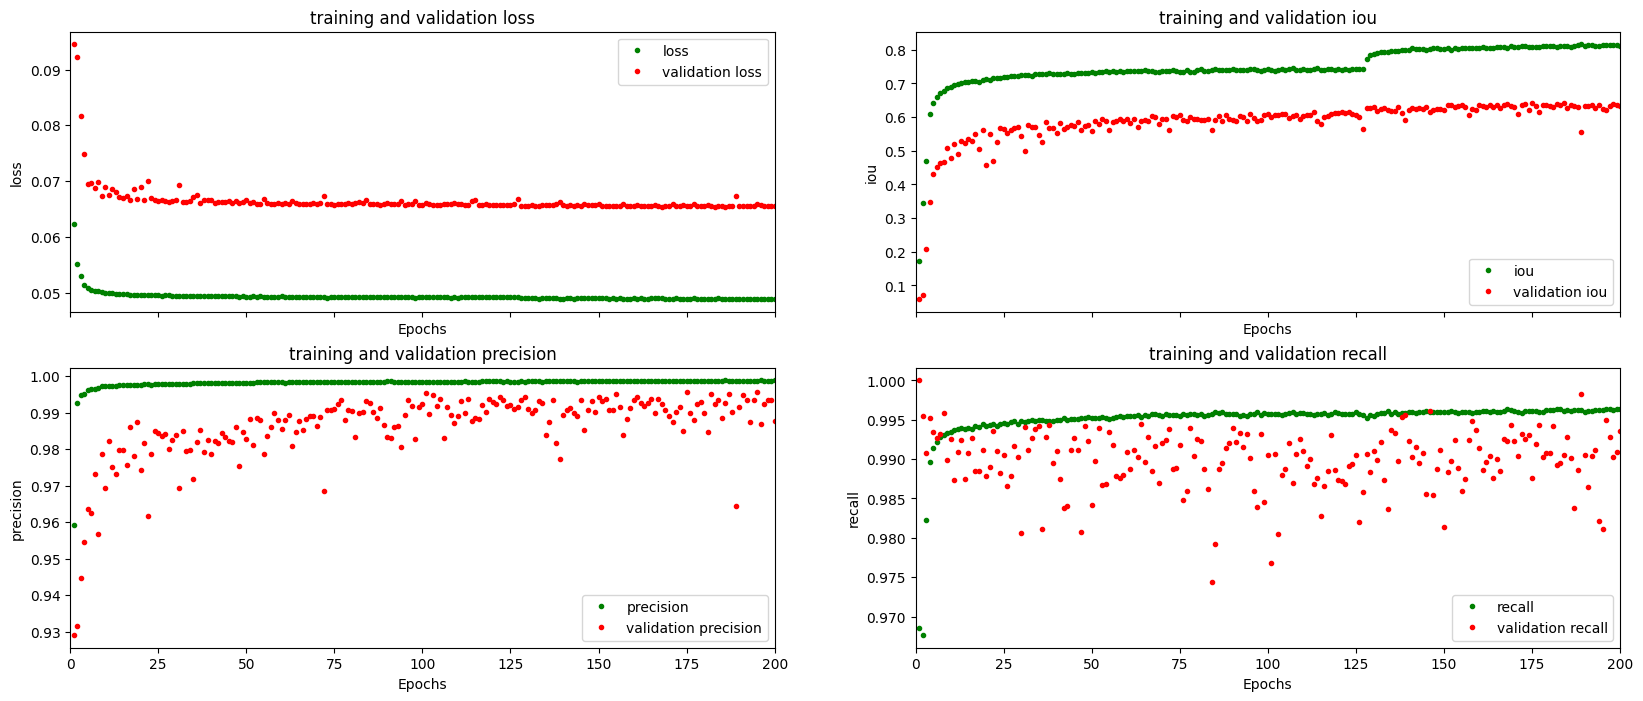

In [103]:
plot_training_history(baseline_history)

Calculate the mean IoU of the baseline model. This plays the role that the further development of the model should have higher score than this.

In [105]:
baseline_evaluation = fcn.evaluate(X_val,y_val_label)

102/102 [==============================] - 4s 39ms/step - loss: 0.0656 - iou: 0.6333 - precision: 0.9876 - recall: 0.9936


In [116]:
print('the iou score of the baseline model is {:.2f}.\nthe precision of the baseline model is {:.2f}.\nthe recall of the baseline model is {:.2f}'.format(baseline_evaluation[1] , baseline_evaluation[2] , baseline_evaluation[3]))

the iou score of the baseline model is 0.63.
the precision of the baseline model is 0.99.
the recall of the baseline model is 0.99


In [173]:
# have the model weights and restart the kernel to save memory
fcn.save_weights("fcn.h5")

## U-Net model

In [15]:
# convolute the image
class convolution_module(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, padding="valid"):
        super().__init__()
        self.conv = Conv2D(filters, kernel_size, padding=padding)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = ReLU()
        
    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.relu(x)
        return x

# downsample would convolute the image twice and do max-pooling
class downsample_module(tf.keras.layers.Layer):
    
    def __init__(self, filters, kernel_size, pool_size, padding="valid"):
        super().__init__()
        self.conv_module1 = convolution_module(filters, kernel_size, padding)
        self.conv_module2 = convolution_module(filters, kernel_size, padding)
        self.maxpool = MaxPooling2D(pool_size)
        
    def call(self, inputs):
        x_skip = self.conv_module1(inputs)
        x_skip = self.conv_module2(x_skip)
        x_max = self.maxpool(x_skip)
        return x_max , x_skip
    
# deconvolute the image
class deconvolution_module(tf.keras.layers.Layer):  
    def __init__(self, filters, kernel_size):
        super().__init__()
        self.deconv = Conv2DTranspose(filters, kernel_size, strides=kernel_size, padding="same")
        self.bn = tf.keras.layers.BatchNormalization()
        
        self.relu = ReLU()
        
    def call(self, inputs):
        x = self.deconv(inputs)
        x = self.bn(x)
        x = self.relu(x) 
        return x
    
# upsample would deconvolute the image once and comvolute twice
class upsample_module(tf.keras.layers.Layer):
    
    def __init__(self, filters, kernel_size, deconv_kernel, padding="valid"):
        super().__init__()
        self.deconv_module = deconvolution_module(filters, deconv_kernel)
        self.conv_module1 = convolution_module(filters, kernel_size, padding)
        self.conv_module2 = convolution_module(filters, kernel_size, padding)
        
    def call(self, inputs):
        x_deconv = self.deconv_module(inputs[0])
#         skip connections
        x_skip = tf.concat([x_deconv , inputs[1]] , axis=3)
        x_conv = self.conv_module1(x_skip)
        x_conv = self.conv_module2(x_conv)
        return x_conv

class double_convolution(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.bottleneck1 = convolution_module(1024, (3,3), 'same')
        self.bottleneck2 = convolution_module(1024, (3,3), 'same')

    def call(self, inputs):
        x = self.bottleneck1(inputs[0])
        x = self.bottleneck2(x)
        return x , inputs[1]

# downsample blocks
class contractive_path(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.downsample1 = downsample_module(64 , (3,3) , (2,2) , 'same')
        self.downsample2 = downsample_module(128, (3,3) , (2,2) , 'same')
        self.downsample3 = downsample_module(256, (3,3) , (2,2) , 'same')
        self.downsample4 = downsample_module(512, (3,3) , (2,2) , 'same')
        self.bottleneck = double_convolution()

    def call(self, inputs):
        x_1 = self.downsample1(inputs)
        x_2 = self.downsample2(x_1[0])
        x_3 = self.downsample3(x_2[0])
        x_4 = self.downsample4(x_3[0])
        x_4 = self.bottleneck(x_4)
        return x_1,x_2,x_3,x_4
    
# upsample blocks
class expansive_path(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.upsample1 = upsample_module(512 ,(3,3) , (2,2) , 'same')
        self.upsample2 = upsample_module(256 , (3,3) , (2,2) , 'same')
        self.upsample3 = upsample_module(128 , (3,3) , (2,2) , 'same')
        self.upsample4 = upsample_module(64 , (3,3) , (2,2) , 'same')

    def call(self, inputs):
        x = self.upsample1([inputs[3][0] , inputs[3][1]])
        x = self.upsample2([x , inputs[2][1]])
        x = self.upsample3([x , inputs[1][1]])
        x = self.upsample4([x , inputs[0][1]])
        return x

In [16]:
class unet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.contractive = contractive_path()
        self.expansive = expansive_path()
        self.dense = Dense(32)
#         last layer to predict the probabilies of each class
        self.softmax = Conv2D(13, (1,1) , activation='softmax')

    def call(self, inputs):
        x = self.contractive(inputs)
        x = self.expansive(x)
        x = self.dense(x)
        x = self.softmax(x)
        return x

In [6]:
u_net = unet()
metrics = [self_iou(num_classes=13) , self_precision() , self_recall()]
optimizer =  tf.keras.optimizers.Adam(learning_rate = 1e-4)
u_net.compile(loss= self_loss , metrics=metrics , optimizer=optimizer)

### Train U-net model

In [18]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss' , patience=20)]
unet_history = u_net.fit( X_train , y_train_label , callbacks = callback, batch_size = 32 , epochs= 200 , validation_data = (X_val , y_val_label))

Epoch 1/200
158/158 [==============================] - 120s 593ms/step - loss: 0.0606 - iou: 0.2697 - precision: 0.9648 - recall: 0.9789 - val_loss: 0.0972 - val_iou: 0.0073 - val_precision: 0.9291 - val_recall: 1.0000
Epoch 2/200
158/158 [==============================] - 80s 505ms/step - loss: 0.0527 - iou: 0.5136 - precision: 0.9963 - recall: 0.9858 - val_loss: 0.0950 - val_iou: 0.0403 - val_precision: 0.9299 - val_recall: 0.9980
Epoch 3/200
158/158 [==============================] - 79s 501ms/step - loss: 0.0504 - iou: 0.6862 - precision: 0.9976 - recall: 0.9941 - val_loss: 0.0862 - val_iou: 0.1989 - val_precision: 0.9406 - val_recall: 0.9972
Epoch 4/200
158/158 [==============================] - 79s 501ms/step - loss: 0.0497 - iou: 0.7214 - precision: 0.9981 - recall: 0.9957 - val_loss: 0.0707 - val_iou: 0.4822 - val_precision: 0.9653 - val_recall: 0.9983
Epoch 5/200
158/158 [==============================] - 79s 501ms/step - loss: 0.0494 - iou: 0.7386 - precision: 0.9983 - recall

158/158 [==============================] - 78s 497ms/step - loss: 0.0479 - iou: 0.9549 - precision: 0.9995 - recall: 0.9995 - val_loss: 0.0642 - val_iou: 0.8298 - val_precision: 0.9903 - val_recall: 0.9982
Epoch 76/200
158/158 [==============================] - 78s 495ms/step - loss: 0.0479 - iou: 0.9540 - precision: 0.9995 - recall: 0.9995 - val_loss: 0.0641 - val_iou: 0.8295 - val_precision: 0.9894 - val_recall: 0.9990
Epoch 77/200
158/158 [==============================] - 78s 495ms/step - loss: 0.0479 - iou: 0.9549 - precision: 0.9995 - recall: 0.9996 - val_loss: 0.0641 - val_iou: 0.8218 - val_precision: 0.9907 - val_recall: 0.9984
Epoch 78/200
158/158 [==============================] - 78s 495ms/step - loss: 0.0479 - iou: 0.9550 - precision: 0.9995 - recall: 0.9996 - val_loss: 0.0642 - val_iou: 0.8235 - val_precision: 0.9886 - val_recall: 0.9992
Epoch 79/200
158/158 [==============================] - 78s 496ms/step - loss: 0.0478 - iou: 0.9561 - precision: 0.9995 - recall: 0.9995 

In [19]:
u_net.save_weights("unet.h5")

### Prediction of U-net model

In [21]:
predictions_unet = u_net.predict(X_val[0:1])
prediction_classes = np.argmax(predictions_unet , axis = 3)

1/1 [==============================] - 11s 11s/step


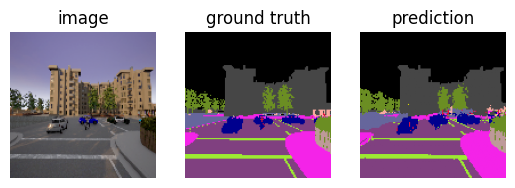

In [25]:
plt.subplot(1,3,1)
plt.imshow(array_to_img(X_val[0]))
plt.title('image')
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(y_val[0])
plt.title('ground truth')
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(labels2pixels(prediction_classes[0],label_list))
plt.title('prediction')
plt.axis("off")

plt.show()

### Evaluation of U-net model

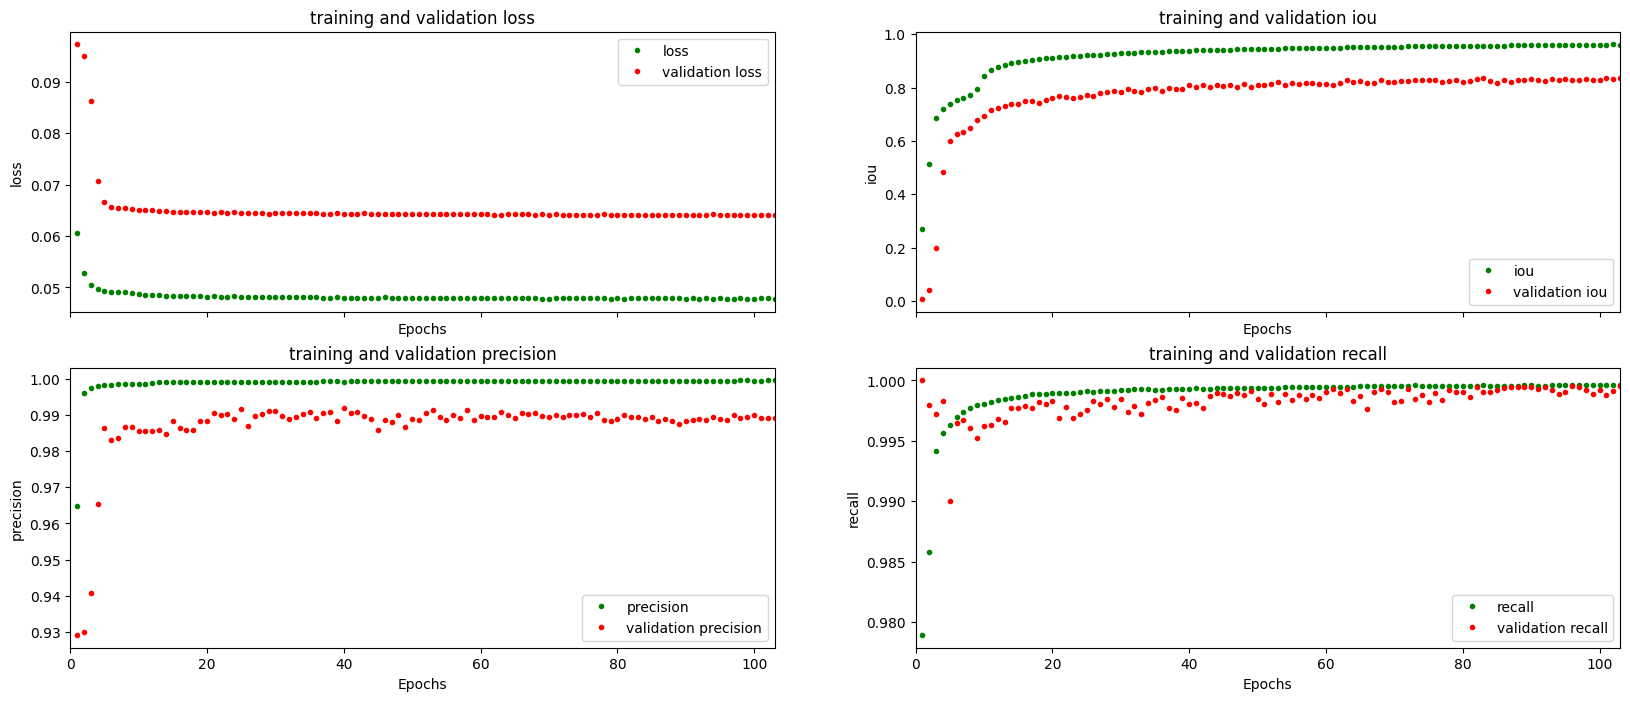

In [25]:
plot_training_history(unet_history)

In [26]:
unet_evaluation = u_net.evaluate(X_val,y_val_label)

102/102 [==============================] - 20s 131ms/step - loss: 0.0641 - iou: 0.8369 - precision: 0.9893 - recall: 0.9995


In [28]:
print('the iou score of the U-net model is {:.2f}.\nthe precision of the U-net model is {:.2f}.\nthe recall of the U-net model is {:.2f}'.format(unet_evaluation[1] , unet_evaluation[2] , unet_evaluation[3]))

the iou score of the U-net model is 0.84.
the precision of the U-net model is 0.99.
the recall of the U-net model is 1.00


## SegNet model

In [30]:
class maxPoolingArgmax(tf.keras.layers.Layer):

    def __init__(self,pool_size,padding='same'):
        super().__init__()
        self.padding = padding
        self.pool_size = pool_size
        self.strides = pool_size

    def call(self, inputs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        ksize = [1, pool_size[0], pool_size[1], 1]
        padding = padding.upper()
        strides = [1, strides[0], strides[1], 1]
        output, argmax = tf.nn.max_pool_with_argmax(
                inputs,
                ksize=ksize,
                strides=strides,
                padding=padding)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax] #return max-pool output and their indices


class maxUnpoolingArgmax(tf.keras.layers.Layer):
    def __init__(self, size):
        super().__init__()
        self.size = size

    def call(self, inputs):
        # one is maxpooling and one is indices mask
        updates, mask = inputs[0], inputs[1]

        with tf.compat.v1.variable_scope(self.name):
            mask = K.cast(mask, 'int32')
            input_shape = tf.shape(updates, out_type='int32')     # it gives a dynamic shape of a given tensor. 

            #  calculation new shape
            output_shape = (
                    input_shape[0],
                    input_shape[1]*self.size[0],
                    input_shape[2]*self.size[1],
                    input_shape[3])

            one_like_mask = K.ones_like(mask, dtype='int32')      #creates ones of the same shape as the mask
            batch_shape = K.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
            batch_range = K.reshape(tf.range(output_shape[0], dtype='int32'),shape=batch_shape)
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = tf.range(output_shape[3], dtype='int32')
            f = one_like_mask * feature_range
            # transpose indices & reshape update values to one dimension
            updates_size = tf.size(updates)       # Prints the number of elements in the updates
            indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            unpool = tf.scatter_nd(indices, values, output_shape)
            return unpool
        
# convolute the image
class convolution_module(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, padding="valid"):
        super().__init__()
        self.conv = Conv2D(filters, kernel_size, padding=padding)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = ReLU()
        
    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.relu(x)
        return x
    
# deconvolute the image
class deconvolution_module(tf.keras.layers.Layer):  
    def __init__(self, filters, kernel_size):
        super().__init__()
        self.deconv = Conv2DTranspose(filters, kernel_size, strides=kernel_size, padding="same")
        self.bn = tf.keras.layers.BatchNormalization()
        
        self.relu = ReLU()
        
    def call(self, inputs):
        x = self.deconv(inputs)
        x = self.bn(x)
        x = self.relu(x) 
        return x

# downsample would convolute the image twice and do max-pooling
class encoder_module(tf.keras.layers.Layer):
    
    def __init__(self, number_of_conv , filters, kernel_size, pool_size, padding="valid"):
        super().__init__()
        self.conv_list = []
        for i in range(number_of_conv):
            self.conv_list.append(convolution_module(filters, kernel_size, padding))
        self.maxpoolargmax = maxPoolingArgmax(pool_size)
        
    def call(self, inputs):
        if len(self.conv_list) == 1:
            x = self.conv_list[0](inputs)
        else:
            x = self.conv_list[0](inputs)
            for i in self.conv_list[1:]:
                x = i(x)
        x_pool , x_indices = self.maxpoolargmax(x)
        return x_pool , x_indices
    
# upsample would deconvolute the image once and comvolute twice
class decoder_module(tf.keras.layers.Layer):
    
    def __init__(self, number_of_conv , filters, kernel_size, pool_size , padding="valid"):
        super().__init__()
        self.conv_list = []
        self.maxunpoolargmax = maxUnpoolingArgmax(pool_size)
        for i in range(number_of_conv - 1):
            self.conv_list.append(convolution_module(filters, kernel_size, padding)) 
        self.conv_last = convolution_module(filters/2 , kernel_size , padding)
       
    def call(self, inputs):
        x = self.maxunpoolargmax(inputs)
        if len(self.conv_list) == 1:
            x = self.conv_list[0](x)
        else:
            x = self.conv_list[0](x)
            for i in self.conv_list[1:]:
                x = i(x)
        x = self.conv_last(x)
        return x
        
class encoder_path(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.encoder1 = encoder_module( 2 , 64 , (3,3) , (2,2) , 'same')
        self.encoder2 = encoder_module( 2 , 128, (3,3) , (2,2) , 'same')
        self.encoder3 = encoder_module( 3 , 256, (3,3) , (2,2) , 'same')
        self.encoder4 = encoder_module( 3 , 512, (3,3) , (2,2) , 'same')
        self.encoder5 = encoder_module( 3 , 1024, (3,3) , (2,2) , 'same')

    def call(self, inputs):
        x_1 = self.encoder1(inputs)
        x_2 = self.encoder2(x_1[0])
        x_3 = self.encoder3(x_2[0])
        x_4 = self.encoder4(x_3[0])
        x_5 = self.encoder5(x_4[0])
        return x_1,x_2,x_3,x_4,x_5
    
class decoder_path(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.decoder1 = decoder_module(3 , 1024 ,(3,3) , (2,2) , 'same')
        self.decoder2 = decoder_module(3 , 512 ,(3,3) , (2,2) , 'same')
        self.decoder3 = decoder_module(3 , 256 , (3,3) , (2,2) , 'same')
        self.decoder4 = decoder_module(2 , 128 , (3,3) , (2,2) , 'same')
        self.decoder5 = decoder_module(2 , 64 , (3,3) , (2,2) , 'same')

    def call(self, inputs):
        x = self.decoder1(inputs[4])
        x = self.decoder2([x, inputs[3][1]])
        x = self.decoder3([x , inputs[2][1]])
        x = self.decoder4([x , inputs[1][1]])
        x = self.decoder5([x , inputs[0][1]])
        return x

In [31]:
class SegNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.encoder = encoder_path()
        self.decoder = decoder_path()
        self.softmax = Dense(13 , activation='softmax')
    
    def call(self,inputs):
        x = self.encoder(inputs)
        x = self.decoder(x)
        x = self.softmax(x)
        return x

In [32]:
segnet = SegNet()

In [33]:
metrics = [self_iou(num_classes=13) , self_precision() , self_recall()]
optimizer =  tf.keras.optimizers.Adam(learning_rate = 1e-4)
segnet.compile(loss=self_loss, metrics=metrics , optimizer = optimizer)

### Train SegNet model

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
segnet_history = segnet.fit(X_train , y_train_label , batch_size = 32 , epochs= 200 , validation_data = (X_val , y_val_label) , callbacks = callback)

Epoch 1/200
158/158 [==============================] - 126s 655ms/step - loss: 0.0683 - iou: 0.0709 - precision: 0.9776 - recall: 0.8853 - val_loss: 0.0952 - val_iou: 0.0058 - val_precision: 0.9291 - val_recall: 1.0000
Epoch 2/200
158/158 [==============================] - 95s 601ms/step - loss: 0.0599 - iou: 0.2242 - precision: 0.9972 - recall: 0.9303 - val_loss: 0.0937 - val_iou: 0.0327 - val_precision: 0.9291 - val_recall: 1.0000
Epoch 3/200
158/158 [==============================] - 91s 577ms/step - loss: 0.0558 - iou: 0.4465 - precision: 0.9964 - recall: 0.9781 - val_loss: 0.0899 - val_iou: 0.1255 - val_precision: 0.9293 - val_recall: 1.0000
Epoch 4/200
158/158 [==============================] - 91s 574ms/step - loss: 0.0533 - iou: 0.6043 - precision: 0.9968 - recall: 0.9897 - val_loss: 0.0751 - val_iou: 0.3556 - val_precision: 0.9479 - val_recall: 0.9984
Epoch 5/200
158/158 [==============================] - 90s 571ms/step - loss: 0.0524 - iou: 0.6469 - precision: 0.9972 - recall

158/158 [==============================] - 85s 542ms/step - loss: 0.0483 - iou: 0.9103 - precision: 0.9993 - recall: 0.9991 - val_loss: 0.0647 - val_iou: 0.7553 - val_precision: 0.9917 - val_recall: 0.9981
Epoch 76/200
158/158 [==============================] - 85s 542ms/step - loss: 0.0482 - iou: 0.9098 - precision: 0.9994 - recall: 0.9991 - val_loss: 0.0646 - val_iou: 0.7667 - val_precision: 0.9940 - val_recall: 0.9979
Epoch 77/200
158/158 [==============================] - 85s 541ms/step - loss: 0.0482 - iou: 0.9118 - precision: 0.9994 - recall: 0.9991 - val_loss: 0.0646 - val_iou: 0.7683 - val_precision: 0.9924 - val_recall: 0.9977
Epoch 78/200
158/158 [==============================] - 85s 541ms/step - loss: 0.0483 - iou: 0.9122 - precision: 0.9994 - recall: 0.9991 - val_loss: 0.0646 - val_iou: 0.7654 - val_precision: 0.9950 - val_recall: 0.9979
Epoch 79/200
158/158 [==============================] - 85s 541ms/step - loss: 0.0482 - iou: 0.9130 - precision: 0.9994 - recall: 0.9991 

158/158 [==============================] - 85s 541ms/step - loss: 0.0481 - iou: 0.9341 - precision: 0.9995 - recall: 0.9994 - val_loss: 0.0644 - val_iou: 0.7953 - val_precision: 0.9934 - val_recall: 0.9982
Epoch 150/200
158/158 [==============================] - 85s 541ms/step - loss: 0.0481 - iou: 0.9340 - precision: 0.9995 - recall: 0.9994 - val_loss: 0.0644 - val_iou: 0.7964 - val_precision: 0.9916 - val_recall: 0.9985
Epoch 151/200
158/158 [==============================] - 86s 542ms/step - loss: 0.0481 - iou: 0.9341 - precision: 0.9995 - recall: 0.9994 - val_loss: 0.0645 - val_iou: 0.7919 - val_precision: 0.9907 - val_recall: 0.9990
Epoch 152/200
158/158 [==============================] - 85s 541ms/step - loss: 0.0481 - iou: 0.9334 - precision: 0.9994 - recall: 0.9994 - val_loss: 0.0644 - val_iou: 0.8037 - val_precision: 0.9916 - val_recall: 0.9985
Epoch 153/200
158/158 [==============================] - 85s 541ms/step - loss: 0.0480 - iou: 0.9338 - precision: 0.9995 - recall: 0.9

In [22]:
segnet.save_weights("segnet.h5")

### Prediction of SegNet

In [23]:
predictions_segnet = segnet.predict(X_val)
prediction_classes = np.argmax(predictions_segnet , axis = 3)

102/102 [==============================] - 22s 202ms/step


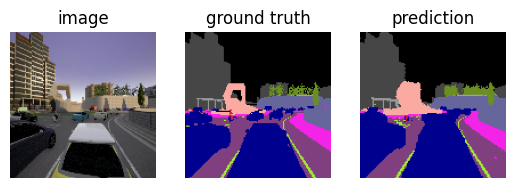

In [26]:
plt.subplot(1,3,1)
plt.imshow(array_to_img(X_val[100]))
plt.title('image')
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(y_val[100])
plt.title('ground truth')
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(labels2pixels(prediction_classes[100],label_list))
plt.title('prediction')
plt.axis("off")

plt.show()

### Evaluation of SegNet

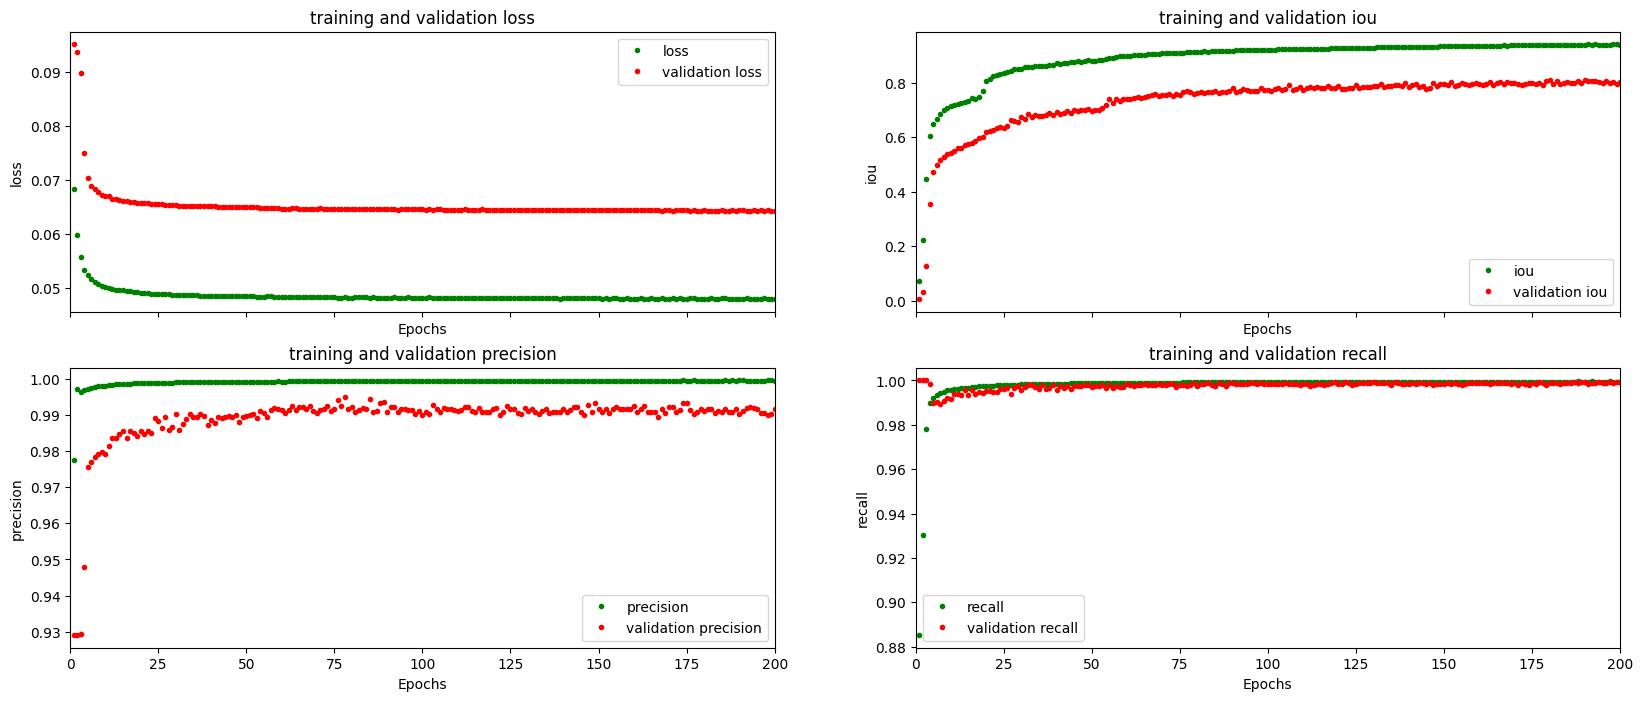

In [25]:
plot_training_history(segnet_history)

In [23]:
segnet_evaluation = segnet.evaluate(X_val , y_val_label)

102/102 [==============================] - 20s 199ms/step - loss: 0.0643 - iou: 0.8021 - precision: 0.9916 - recall: 0.9992


In [24]:
print('the iou score of the SegNet model is {:.2f}.\nthe precision of the SegNet model is {:.2f}.\nthe recall of the SegNet model is {:.2f}'.format(segnet_evaluation[1] , segnet_evaluation[2] , segnet_evaluation[3]))

the iou score of the SegNet model is 0.80.
the precision of the SegNet model is 0.99.
the recall of the SegNet model is 1.00


## Models evaluation
Now, I am going to compare the performance of the models.

### mIoU

In [29]:
# add the trained weights to the model
fcn_2 = fully_convolutional_network()
metrics = [self_iou(num_classes=13) , self_precision() , self_recall()]
fcn_2.compile(loss= self_loss , metrics=metrics)
fcn_2(tf.keras.Input(shape=(np.shape(X_train[0]))))
fcn_2.load_weights('fcn.h5')

In [40]:
fcn2_eval = fcn_2.evaluate(X_val , y_val_label)

102/102 [==============================] - 13s 39ms/step - loss: 0.0656 - iou: 0.6333 - precision: 0.9876 - recall: 0.9936


In [34]:
unet_2 = unet()
metrics = [self_iou(num_classes=13) , self_precision() , self_recall()]
unet_2.compile(loss= self_loss , metrics=metrics)
unet_2(tf.keras.Input(shape=(128,128,3)))
unet_2.load_weights('unet.h5')

In [47]:
unet_2_eval = unet_2.evaluate(X_val , y_val_label)

102/102 [==============================] - 17s 130ms/step - loss: 0.0641 - iou: 0.8368 - precision: 0.9893 - recall: 0.9995


In [36]:
segnet(tf.keras.Input(shape=(np.shape(X_train[0]))))
segnet.load_weights('segnet.h5')

In [49]:
# show the results of each model
d = {'FCN' : fcn2_eval[1:] , 'U-net' : unet_2_eval[1:]  ,'SegNet' : segnet_evaluation[1:] }
eval_df = pd.DataFrame(data = d , index = ['IoU' , 'Precision' , 'Recall'])
eval_df.to_csv('models_evaluation')
eval_df

,FCN,U-net,SegNet
IoU,0.633328,0.836781,0.802084
Precision,0.987609,0.989301,0.991560
Recall,0.993591,0.999549,0.999193


In [180]:
def plot_predictions(models):
    fig,axs = plt.subplots( 5 , len(models)+2 ,sharex='all'  , figsize=(20,20))
    
    indices = np.random.random_integers(1 , high=len(X_val) , size = 5)
    x = np.array([X_val[i] for i in indices])
    for m in range(len(models)):
        preds = models[m].predict(x)
        preds_label = [np.argmax(l , axis = 2) for l in preds]
        for i in range(len(indices)):
            if m == 0:
                plt.subplot(5, len(models)+2 , i*5 + 1 )
                plt.title('image')
                plt.imshow(array_to_img(X_val[indices[i]]))
                plt.axis('off')

                plt.subplot(5, len(models)+2 , i*5 + 2 )
                plt.title('ground truth')
                plt.imshow(y_val[indices[i]])
                plt.axis('off')
                
                plt.subplot(5, len(models)+2 , i*5 + 3 )
                plt.title('baseline model')
                plt.imshow(labels2pixels(preds_label[i] , label_list))
                plt.axis('off')
            
            elif m == 1 :
                plt.subplot(5, len(models)+2 , i*5 + 4 )
                plt.title('unet')
                plt.imshow(labels2pixels(preds_label[i] , label_list))
                plt.axis('off')
                
            else:
                plt.subplot(5, len(models)+2 , i*5 + 5 )
                plt.title('segnet')
                plt.imshow(labels2pixels(preds_label[i] , label_list))
                plt.axis('off')

    plt.show()

1/1 [==============================] - 0s 104ms/step


C:\Users\RYUGAAX\AppData\Local\Temp\ipykernel_7712\3794140681.py:4: DeprecationWarning: This function is deprecated. Please call randint(1, 3245 + 1) instead
  indices = np.random.random_integers(1 , high=len(X_val) , size = 5)


1/1 [==============================] - 0s 172ms/step


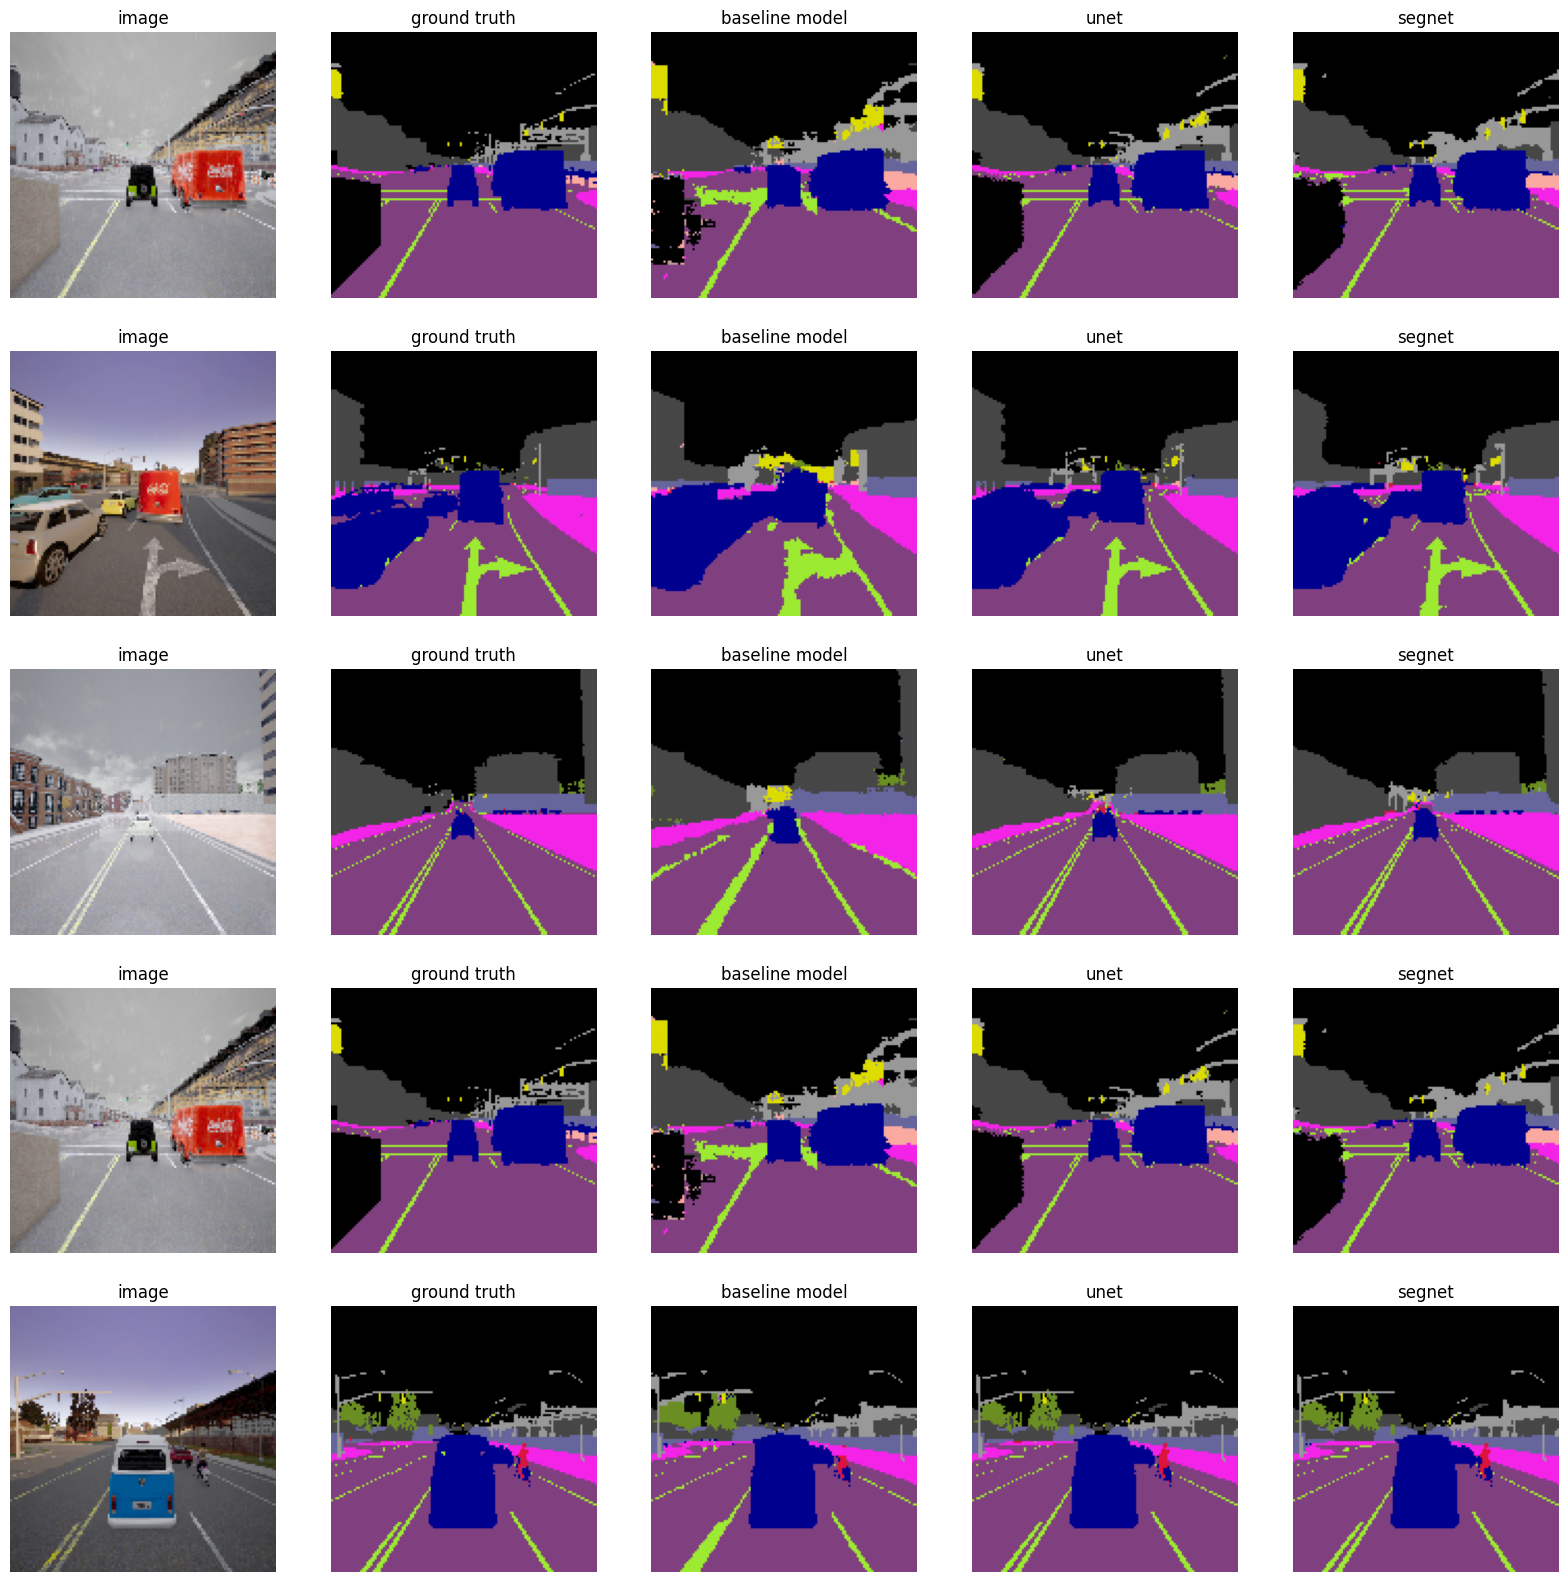

In [183]:
# plot the predictions of each model
plot_predictions([fcn_2 , unet_2 , segnet])

### Predictions per frame
Compute how many frames the models can process in one second.

In [61]:
start_time = time.time()

class test_model_with_video:
    def __init__(self, model, video_path):
        self.model = model
        self.model_name = model.name
        self.video = cv2.VideoCapture(video_path)
        self.starting_time = None
        self.ending_time = None
        self.frames = 457
        self.fps = None
        
    def test(self):
        self.starting_time = time.time()
        while True:
            check, frame = self.video.read()
            # exit the loop if there are no more frames to read
            if check == False:
                break;
        
            frame_norm = normalize_img(frame)[np.newaxis , : , :] 
            self.model.predict(frame_norm,verbose = 0)
        self.ending_time = time.time()
        self.fps = self.frames/(self.ending_time - self.starting_time)
        self.video.release()

In [62]:
model_test1 = test_model_with_video(u_net , 'dataset/video footage picture.mp4')
model_test2 = test_model_with_video(segnet, 'dataset/video footage picture.mp4')

In [63]:
model_test1.test()

In [64]:
model_test2.test()

In [76]:
# show the results
d = {model_test1.model_name : model_test1.fps , model_test2.model_name : model_test2.fps}
eval_df = pd.DataFrame(data = d , index = ['fps'])
eval_df.to_csv('models_video_evaluation')
eval_df

,unet_1,seg_net
fps,17.970638,15.572701


# Fine tuning model

## Data augmentation
There is a 33% of chance to happen either flipping the image horizontally, cropping the image or adjusting the brightness

In [215]:
def adjust_brightness(img):
    rdm = np.random.random()/2
    img_new = tf.image.adjust_brightness(X_test[0], delta=0.4)
    return img_new

def flip(img):
    img_new = tf.image.flip_left_right(img)
    return img_new

def crop(img):
    rdm = random.uniform(0.4, 0.8)
    img_new = resize_images(tf.image.central_crop(img,rdm))
    return img_new

def data_augmentation(img , lbl):
    rdm = np.random.random()
    rdm = float(f"{rdm:.2f}")
    if rdm <= 0.33:
        img_new = adjust_brightness(img)
        lbl_new = lbl
    elif rdm>0.33 and rdm<=0.66:
        img_new = flip(img)
        lbl_new = flip(lbl)
    else:
        img_new = crop(img)
        lbl_new = crop(lbl)
    return img_new , lbl_new

In [216]:
def data_postprocess(x,y):
    X_train_aug = []
    y_train_aug = []

    for i in range(len(x)):
        rdm = np.random.random()
        rdm = float(f"{rdm:.2f}") 
        if rdm <=0.4:
            img , lbl = data_augmentation(X_train[i] , y_train[i])
            X_train_aug.append(img)
            y_train_aug.append(lbl)
        else:
            X_train_aug.append(X_train[i])
            y_train_aug.append(y_train[i])
    return np.array(X_train_aug) , np.array(y_train_aug)

In [217]:
X_train_aug , y_train_aug = data_postprocess(X_train , y_train)

In [221]:
y_train_label_aug = np.array([pixels2labels(i , label_list) for i in y_train_aug])

### Model training

In [220]:
u_net_tuned = unet()
metrics = [self_iou(num_classes=13) , self_precision() , self_recall()]
optimizer =  tf.keras.optimizers.Adam(learning_rate = 1e-4)
u_net_tuned.compile(loss= self_loss , metrics=metrics , optimizer=optimizer)

In [222]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
unet_tuned_history = u_net_tuned.fit(X_train_aug , y_train_label_aug , batch_size = 32 , epochs= 200 , validation_data = (X_val , y_val_label) , callbacks = callback)

Epoch 1/200
158/158 [==============================] - 111s 571ms/step - loss: 0.0678 - iou: 0.1610 - precision: 0.9758 - recall: 0.8992 - val_loss: 0.0974 - val_iou: 0.0065 - val_precision: 0.9291 - val_recall: 1.0000
Epoch 2/200
158/158 [==============================] - 77s 490ms/step - loss: 0.0606 - iou: 0.3260 - precision: 0.9874 - recall: 0.9593 - val_loss: 0.0935 - val_iou: 0.0729 - val_precision: 0.9291 - val_recall: 1.0000
Epoch 3/200
158/158 [==============================] - 77s 490ms/step - loss: 0.0581 - iou: 0.4570 - precision: 0.9915 - recall: 0.9748 - val_loss: 0.0847 - val_iou: 0.2139 - val_precision: 0.9396 - val_recall: 0.9976
Epoch 4/200
158/158 [==============================] - 77s 491ms/step - loss: 0.0566 - iou: 0.5451 - precision: 0.9924 - recall: 0.9818 - val_loss: 0.0685 - val_iou: 0.4693 - val_precision: 0.9733 - val_recall: 0.9858
Epoch 5/200
158/158 [==============================] - 78s 492ms/step - loss: 0.0559 - iou: 0.5717 - precision: 0.9933 - recall

158/158 [==============================] - 77s 490ms/step - loss: 0.0537 - iou: 0.7532 - precision: 0.9967 - recall: 0.9942 - val_loss: 0.0647 - val_iou: 0.7506 - val_precision: 0.9841 - val_recall: 0.9978
Epoch 39/200
158/158 [==============================] - 77s 489ms/step - loss: 0.0537 - iou: 0.7547 - precision: 0.9965 - recall: 0.9942 - val_loss: 0.0647 - val_iou: 0.7554 - val_precision: 0.9864 - val_recall: 0.9979
Epoch 40/200
158/158 [==============================] - 77s 489ms/step - loss: 0.0536 - iou: 0.7548 - precision: 0.9967 - recall: 0.9940 - val_loss: 0.0649 - val_iou: 0.7484 - val_precision: 0.9851 - val_recall: 0.9983
Epoch 41/200
158/158 [==============================] - 77s 489ms/step - loss: 0.0537 - iou: 0.7583 - precision: 0.9968 - recall: 0.9943 - val_loss: 0.0650 - val_iou: 0.7410 - val_precision: 0.9844 - val_recall: 0.9985
Epoch 42/200
158/158 [==============================] - 77s 490ms/step - loss: 0.0537 - iou: 0.7557 - precision: 0.9966 - recall: 0.9942 

158/158 [==============================] - 77s 489ms/step - loss: 0.0535 - iou: 0.7832 - precision: 0.9968 - recall: 0.9951 - val_loss: 0.0647 - val_iou: 0.7613 - val_precision: 0.9864 - val_recall: 0.9987
Epoch 76/200
158/158 [==============================] - 77s 488ms/step - loss: 0.0535 - iou: 0.7833 - precision: 0.9969 - recall: 0.9951 - val_loss: 0.0646 - val_iou: 0.7713 - val_precision: 0.9837 - val_recall: 0.9990
Epoch 77/200
158/158 [==============================] - 77s 488ms/step - loss: 0.0534 - iou: 0.7848 - precision: 0.9969 - recall: 0.9952 - val_loss: 0.0647 - val_iou: 0.7689 - val_precision: 0.9827 - val_recall: 0.9992
Epoch 78/200
158/158 [==============================] - 77s 488ms/step - loss: 0.0533 - iou: 0.7830 - precision: 0.9969 - recall: 0.9952 - val_loss: 0.0646 - val_iou: 0.7691 - val_precision: 0.9833 - val_recall: 0.9991
Epoch 79/200
158/158 [==============================] - 77s 489ms/step - loss: 0.0534 - iou: 0.7835 - precision: 0.9970 - recall: 0.9952 

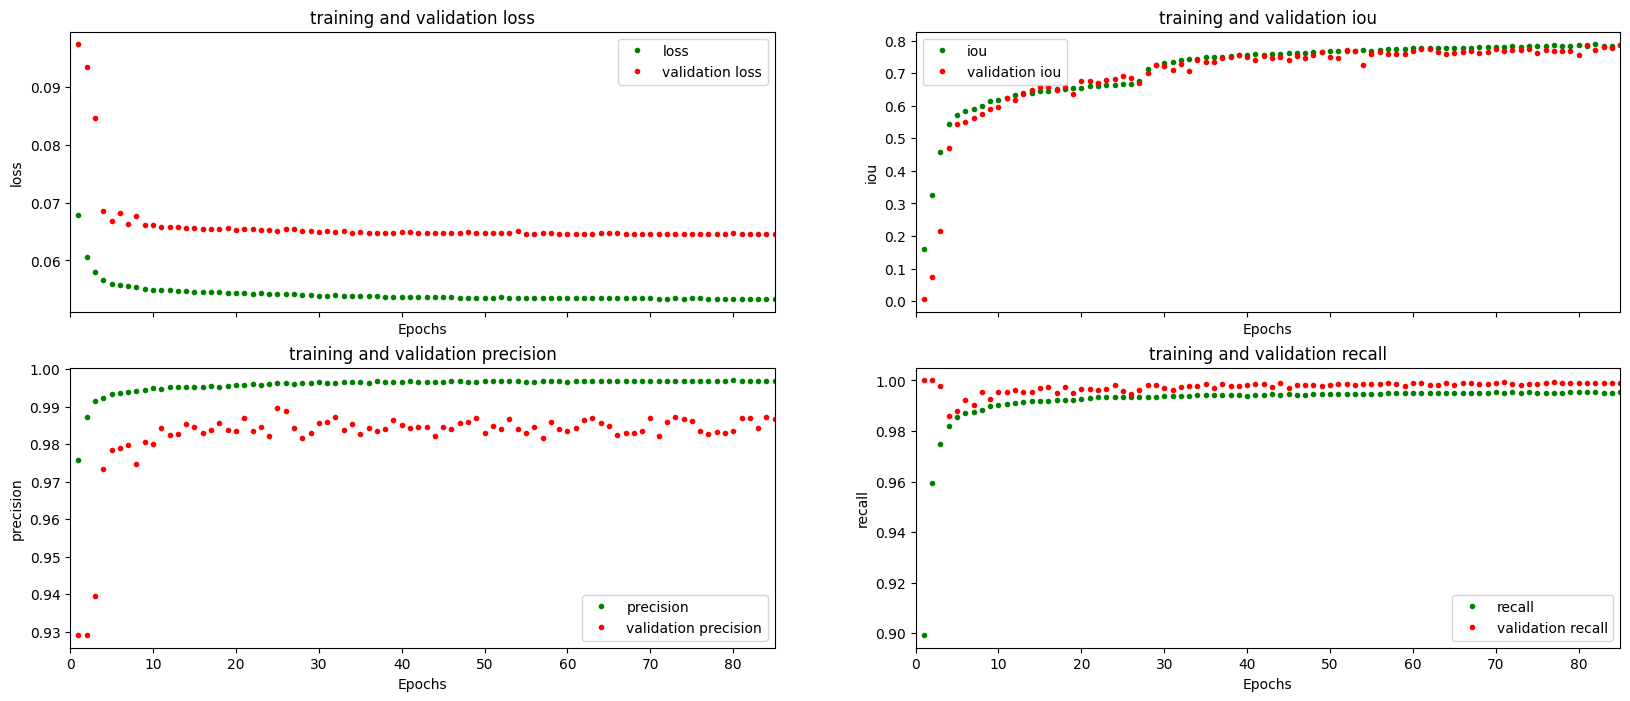

In [225]:
plot_training_history(unet_tuned_history)

## K-cross validation

In [38]:
u_net = unet()
metrics = [self_iou(num_classes=13) , self_precision() , self_recall()]
optimizer =  tf.keras.optimizers.Adam(learning_rate = 1e-4)
u_net.compile(loss= self_loss , metrics=metrics , optimizer=optimizer)
epochs = 20 
batch_size = 32

Concatenate the initial training and validation dataset.

In [25]:
X_total = np.concatenate((X_train , X_val))
y_total = np.concatenate((y_train_label , y_val_label))

Splitting the dataset into 5 parts.

In [28]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

Iterate over the subsets.

In [39]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
metrics = []
for train_index, test_index in kfold.split(X_total):
    X_train_fold, X_test_fold = X_total[train_index], X_total[test_index]
    y_train_fold, y_test_fold = y_total[train_index], y_total[test_index]
    u_net_kval = u_net.fit(X_train_fold , y_train_fold , batch_size = batch_size , epochs= epochs , validation_data = (X_test_fold , y_test_fold) , callbacks = callback)
    metrics.append(u_net_kval)
    print(u_net.evaluate(X_test_fold , y_test_fold))

Epoch 1/20
208/208 [==============================] - 100s 446ms/step - loss: 0.0633 - iou: 0.2645 - precision: 0.9923 - recall: 0.9588 - val_loss: 0.0805 - val_iou: 0.0060 - val_precision: 0.9234 - val_recall: 1.0000
Epoch 2/20
208/208 [==============================] - 91s 438ms/step - loss: 0.0554 - iou: 0.6188 - precision: 0.9972 - recall: 0.9936 - val_loss: 0.0762 - val_iou: 0.0945 - val_precision: 0.9289 - val_recall: 0.9997
Epoch 3/20
208/208 [==============================] - 91s 439ms/step - loss: 0.0536 - iou: 0.7217 - precision: 0.9982 - recall: 0.9965 - val_loss: 0.0569 - val_iou: 0.6259 - val_precision: 0.9910 - val_recall: 0.9981
Epoch 4/20
208/208 [==============================] - 91s 439ms/step - loss: 0.0532 - iou: 0.7466 - precision: 0.9989 - recall: 0.9963 - val_loss: 0.0574 - val_iou: 0.5780 - val_precision: 0.9855 - val_recall: 0.9986
Epoch 5/20
208/208 [==============================] - 91s 439ms/step - loss: 0.0531 - iou: 0.7855 - precision: 0.9988 - recall: 0.9

Epoch 18/20
208/208 [==============================] - 90s 433ms/step - loss: 0.0517 - iou: 0.9515 - precision: 0.9997 - recall: 0.9995 - val_loss: 0.0523 - val_iou: 0.9371 - val_precision: 0.9993 - val_recall: 0.9992
Epoch 19/20
208/208 [==============================] - 90s 434ms/step - loss: 0.0517 - iou: 0.9528 - precision: 0.9996 - recall: 0.9995 - val_loss: 0.0524 - val_iou: 0.9346 - val_precision: 0.9989 - val_recall: 0.9994
Epoch 20/20
52/52 [==============================] - 7s 129ms/step - loss: 0.0524 - iou: 0.9347 - precision: 0.9991 - recall: 0.9994
[0.052354682236909866, 0.9347328543663025, 0.9990504384040833, 0.9994110465049744]
Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node 'unet_2/expansive_path_2/upsample_module_11/convolution_module_52/batch_normalization_64/FusedBatchNormV3' defined at (most recent call last):
    File "D:\anaconda\envs\gpu1\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "D:\anaconda\envs\gpu1\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "D:\anaconda\envs\gpu1\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "D:\anaconda\envs\gpu1\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "D:\anaconda\envs\gpu1\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "D:\anaconda\envs\gpu1\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "D:\anaconda\envs\gpu1\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "D:\anaconda\envs\gpu1\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "D:\anaconda\envs\gpu1\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\anaconda\envs\gpu1\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "D:\anaconda\envs\gpu1\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "D:\anaconda\envs\gpu1\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "D:\anaconda\envs\gpu1\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "D:\anaconda\envs\gpu1\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "D:\anaconda\envs\gpu1\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "D:\anaconda\envs\gpu1\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "D:\anaconda\envs\gpu1\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\anaconda\envs\gpu1\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\anaconda\envs\gpu1\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\anaconda\envs\gpu1\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\RYUGAAX\AppData\Local\Temp\ipykernel_14096\1161602724.py", line 6, in <module>
      u_net_kval = u_net.fit(X_train_fold , y_train_fold , batch_size = batch_size , epochs= epochs , validation_data = (X_test_fold , y_test_fold) , callbacks = callback)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\RYUGAAX\AppData\Local\Temp\ipykernel_14096\3023360619.py", line 11, in call
      x = self.expansive(x)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\RYUGAAX\AppData\Local\Temp\ipykernel_14096\3210963547.py", line 102, in call
      x = self.upsample4([x , inputs[0][1]])
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\RYUGAAX\AppData\Local\Temp\ipykernel_14096\3210963547.py", line 57, in call
      x_conv = self.conv_module1(x_skip)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\RYUGAAX\AppData\Local\Temp\ipykernel_14096\3210963547.py", line 11, in call
      x = self.bn(x)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'unet_2/expansive_path_2/upsample_module_11/convolution_module_52/batch_normalization_64/FusedBatchNormV3'
Detected at node 'unet_2/expansive_path_2/upsample_module_11/convolution_module_52/batch_normalization_64/FusedBatchNormV3' defined at (most recent call last):
    File "D:\anaconda\envs\gpu1\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "D:\anaconda\envs\gpu1\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "D:\anaconda\envs\gpu1\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "D:\anaconda\envs\gpu1\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "D:\anaconda\envs\gpu1\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "D:\anaconda\envs\gpu1\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "D:\anaconda\envs\gpu1\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "D:\anaconda\envs\gpu1\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "D:\anaconda\envs\gpu1\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\anaconda\envs\gpu1\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "D:\anaconda\envs\gpu1\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "D:\anaconda\envs\gpu1\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "D:\anaconda\envs\gpu1\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "D:\anaconda\envs\gpu1\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "D:\anaconda\envs\gpu1\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "D:\anaconda\envs\gpu1\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "D:\anaconda\envs\gpu1\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\anaconda\envs\gpu1\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\anaconda\envs\gpu1\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\anaconda\envs\gpu1\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\RYUGAAX\AppData\Local\Temp\ipykernel_14096\1161602724.py", line 6, in <module>
      u_net_kval = u_net.fit(X_train_fold , y_train_fold , batch_size = batch_size , epochs= epochs , validation_data = (X_test_fold , y_test_fold) , callbacks = callback)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\RYUGAAX\AppData\Local\Temp\ipykernel_14096\3023360619.py", line 11, in call
      x = self.expansive(x)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\RYUGAAX\AppData\Local\Temp\ipykernel_14096\3210963547.py", line 102, in call
      x = self.upsample4([x , inputs[0][1]])
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\RYUGAAX\AppData\Local\Temp\ipykernel_14096\3210963547.py", line 57, in call
      x_conv = self.conv_module1(x_skip)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\RYUGAAX\AppData\Local\Temp\ipykernel_14096\3210963547.py", line 11, in call
      x = self.bn(x)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "D:\anaconda\envs\gpu1\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'unet_2/expansive_path_2/upsample_module_11/convolution_module_52/batch_normalization_64/FusedBatchNormV3'
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[32,64,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node unet_2/expansive_path_2/upsample_module_11/convolution_module_52/batch_normalization_64/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[confusion_matrix/assert_less_1/Assert/AssertGuard/pivot_f/_77/_175]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[32,64,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node unet_2/expansive_path_2/upsample_module_11/convolution_module_52/batch_normalization_64/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_220325]

### Evaluating the model

In [78]:
loss_concat = {} 
loss_concat['loss'] = np.concatenate((metrics[0].history['loss'] , metrics[1].history['loss']))
loss_concat['iou'] = np.concatenate((metrics[0].history['iou'] , metrics[1].history['iou']))
loss_concat['val_loss'] = np.concatenate((metrics[0].history['val_loss'] , metrics[1].history['val_loss']))
loss_concat['val_iou'] = np.concatenate((metrics[0].history['val_iou'] , metrics[1].history['val_iou']))

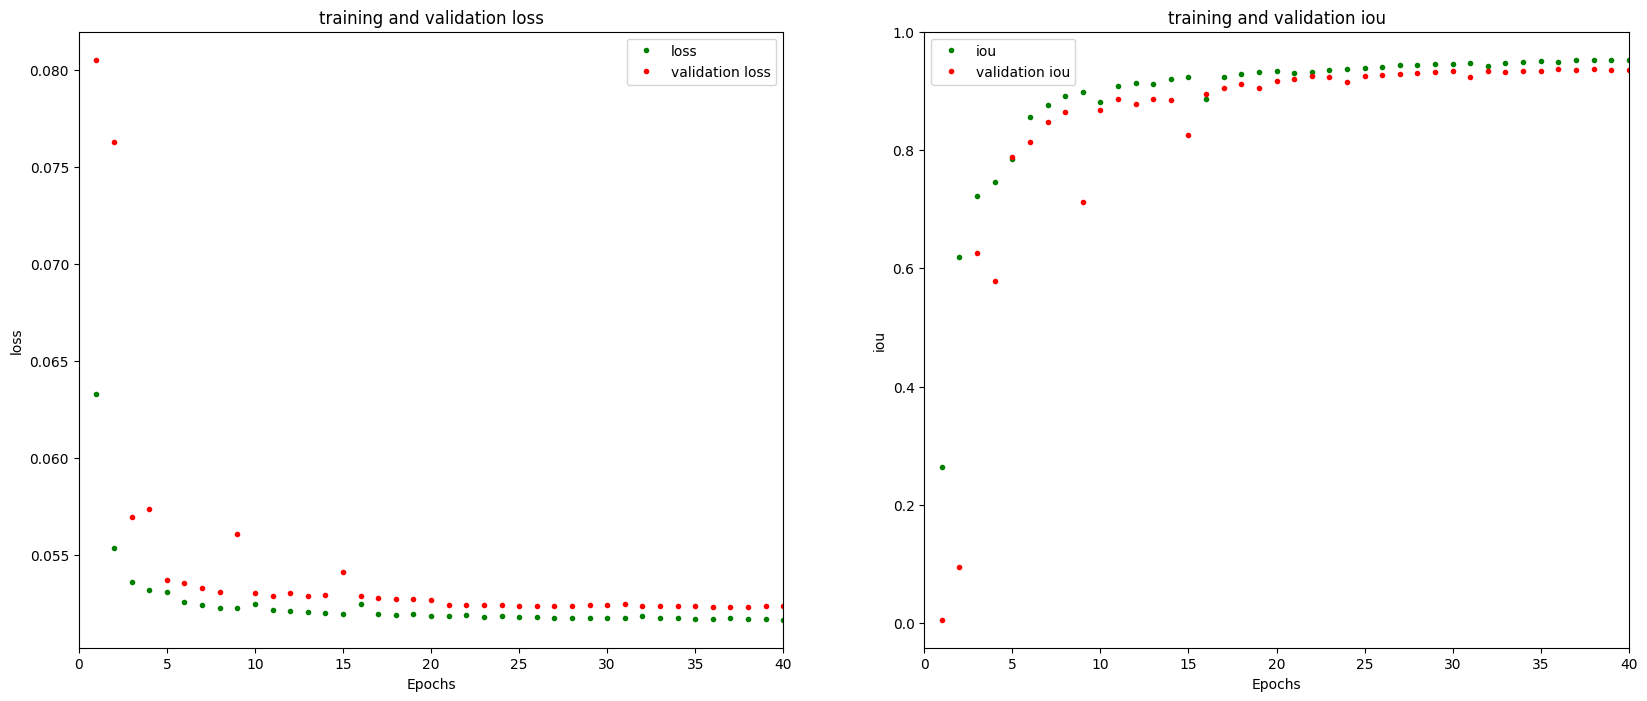

In [80]:
# def plot_training_history(history , monitors=['loss' , 'iou' , 'precision' , 'recall']):
monitors=['loss' , 'iou']
fig,axs = plt.subplots(1,2,sharex='all',figsize=(20,8))

for ax,monitor in zip(axs.flat,monitors):
    loss , val_loss = loss_concat[monitor] , loss_concat['val_' + monitor]

    epochs = range(1,len(loss)+1)

    ax.plot(epochs , loss , 'g.' , label = monitor)
    ax.plot(epochs , val_loss , 'r.' , label='validation ' + monitor)
    ax.set_xlim([0,len(loss)])
    ax.title.set_text('training and validation '+monitor)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(monitor)
    ax.legend()

plt.show()

In [85]:
u_net.evaluate(X_val, y_val_label)

102/102 [==============================] - 20s 142ms/step - loss: 0.0634 - iou: 0.9501 - precision: 1.0000 - recall: 0.9997


[0.06343850493431091, 0.9501435160636902, 1.0, 0.9997498989105225]

The U-net model performs better than before now, having a 95% IoU with the validation dataset.

# Testing model

In [121]:
u_net.evaluate(X_test,y_test_label)

78/78 [==============================] - 12s 147ms/step - loss: 0.0495 - iou: 0.9025 - precision: 0.9977 - recall: 0.9992


[0.049508970230817795,
 0.9024973511695862,
 0.9977281093597412,
 0.9992121458053589]

The model having 90% IoU with the test dataset which is an unseen dataset. It performs excellently. Now, I would use the model to predict the frames of a video footage and show the result.

In [89]:
# predicts the frames of the video 'video footage picture.mp4'
video = cv2.VideoCapture('dataset/video footage picture.mp4')    
img_arr = []

while True:
    check, frame = video.read()
    # exit the loop if there are no more frames to read
    if check == False:
        break;
    else:
        frame_norm = normalize_img(frame)[np.newaxis, : , :]
        pred = u_net.predict(frame_norm , verbose = 0)[0]
        pred_argmax = np.argmax(pred, axis=2)
        pred_classes = labels2pixels(pred_argmax , label_list)
        img_arr.append(pred_classes)
    
    
video.release()

In [123]:
# write the frames into a video file.
out = cv2.VideoWriter('prediction.mp4',cv2.VideoWriter_fourcc(*'MPV4'), 24 , (128,128))

for i in range(len(img_arr)):
    img = (img_arr[i]*255).astype(np.uint8)
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    out.write(img_bgr)

out.release()

See the **prediction.mp4** for the predictions outcome.